# Computer Vision PS (WS21/22)

## Exercise sheet A (ExA)

**Group members**: Ilpo Viertola

**Total (possible) points**: 8 (+1 bonus point)

---

In [52]:
import torch
import time
import math
import numpy as np

## ExA.1 (2 points)

In this exercise, you have to create a 2D tensor (i.e., a matrix) $\mathbf{A}$ of size $20 \times 20$ and fill all entries $a_{ij}, 1 \leq i,j\leq 20$ with values drawn from a Gaussian distribution with mean 3 and a standard deviation of 1.5, i.e., $\mathcal{N}(3,1.5)$. Leverage PyTorch functionality as much as possible.

In [2]:
use_gpu = True
if torch.cuda.is_available() and use_gpu: 
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

A = torch.empty(20,20).normal_(3,1.5)

In [3]:
#
# Testing code 
#
print('Mean of tensor:      {:.3f}'.format(A.mean()))
print('Std. dev. of tensor: {:.3f}'.format(A.std()))

Mean of tensor:      3.143
Std. dev. of tensor: 1.492


## ExA.2 (4 points)

In this exercise, we first create a 2D `numpy.ndarray` named `inp` (size $2 \times 8$) of type `np.float32`. We interpret `inp` as each row representing a 1D signal of length 8.

In [86]:
inp = np.array([[1,2,3,4,5,6,7,8],
               [10,11,12,13,14,15,16,17]]).astype(np.float32)

Your task is to *decompose* the two 1D signals into **sliding windows** and store the results in a tensor.

In particular, we want to slide a window of length $L$ over each signal, where the window is moved forward by $S>=1$ steps a time. In this exercise, set $L=3$ and $S=2$. 

To give a concrete example of such a **sliding window decomposition**, take the first 1D signal `[1,2,3,4,5,6,7,8]`. Under the settings, i.e., $L=3$ and $S=1$, the result would be `[1,2,3]`, `[3,4,5]`, `[5,6,7]`. In other words, we obtain three sliding windows, each of length 3. We could now do this for the second signal as well. As both 1D signals are of equal length (here 8), the overall result (for the two 1D signals) can be stored in a tensor of size `(2,3,3)`. 

*Obviously, your code should produce such a tensor for the given input `inp`, but it should also be possible to handle more than two signals and not just be limited to signals of length 8.*

**Implementation hints**:

One (quite efficient way) to implement this is to use the method `sliding_window_view` from `numpy.lib.stride_tricks` (this requires `numpy` version $\geq$ 1.20.0); see documentation [here](https://numpy.org/devdocs/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html).

Once you have correctly called `numpy.lib.stride_tricks.sliding_window_view`, the result will again be a `numpy.ndarray`, so you have to convert it into a PyTorch tensor. 

To take the step size $S$ into account, you can simply use the slicing syntax of PyTorch tensors. Any singleton dimension can eventually be *squeezed* using `torch.Tensor.squeeze`.



In [90]:
from numpy.lib.stride_tricks import sliding_window_view

def slice_signal(x, win_len, step):
    ret = []
    for i in range(0, len(x), step):
        try:
            tmp = x[i:int(i + win_len)]
            if len(tmp) == win_len:
                ret.append(list(tmp))
        except IndexError:
            break
    return ret

def win(X, L=3, S=2):
    """
    Implementation of the sliding window decomposition.
    
    Arguments:
        X: numpy.ndarray
           Input numpy.ndarray of size (N,D), i.e., N 1D signals of length D

        L: int            
           Length of the sliding window (e.g., 3)
        
        S: int
           Step size to move the sliding window forward (e.g., 2)
            
    Returns:
        torch.Tensor
            Output tensor of size (N,W,width), i.e., N 1D signals, decomposed
            into W windows of length L
        
        
    """
    
    ret = np.apply_along_axis(slice_signal, axis=1, arr=inp, win_len=L, step=S)
    return torch.from_numpy(ret)

In [94]:
#
# Testing code
#
ret = win(inp,3,2)
print(ret.shape)
print(ret)

torch.Size([2, 3, 3])
tensor([[[ 1.,  2.,  3.],
         [ 3.,  4.,  5.],
         [ 5.,  6.,  7.]],

        [[10., 11., 12.],
         [12., 13., 14.],
         [14., 15., 16.]]])


While you do not have to follow the **implementation hints** above, you will get a bonus point if your code runs efficiently. E.g., you can time your code via

In [93]:
inp_large = torch.rand(250,1000)

t1 = time.time()
win(inp_large, 3, 2)
print("Handling of the large input took: ", (time.time() - t1) * 10**6, 
      "microseconds")

%timeit win(inp_large, 3, 2)

Handling of the large input took:  325.91819763183594 microseconds
64.7 µs ± 5.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


If implemented in a reasonably efficient manner, this should run in approx. 700-900 $\mu$s (obviously depending on your system).

## ExA.3 (1 point)

Below, we initialize a tensor of size `(3,4,6,7,10)` with elements drawn from a standard Gaussian distribution, i.e., $\mathcal{N}(0,1)$. Compute the Frobenius norm over all $7 \times 10$ matrices in the last two dimensions. This should give a tensor of size `(3,4,6)`. With the testing code below, you can verify if your solution is correct.

In [41]:
torch.manual_seed(1234)
R = torch.randn(3,4,6,7,10)

In [50]:
#
# YOUR CODE GOES HERE
# 
normR = R.norm(dim=[3,4])

torch.Size([3, 4, 6])

In [51]:
#
# Testing code
#
testR = torch.from_numpy(np.load('/Users/ilpoviertola/Repositories/computer-vision/teaching/WS2122/CV/PS/ExA/testR.npy'))
print('Diff: {:.3f}'.format(torch.linalg.norm(testR-normR)))

Diff: 0.000


## ExA.4 (1 point)

Implement the following two functions:

- $f_0: \mathbb{R} \to \mathbb{R}$, $x \mapsto \max\{0,x\}$ 
- $f_1: \mathbb{R} \to \mathbb{R}$, $x \mapsto \frac{1}{1+e^{-x}}$ 


and plot the function graph for 100 inputs, linearly spaced in $[-5,5]$. To generate such linearly spaced inputs, you can use `torch.linspace`.


In [80]:
def f0(inp):
    return max(0, inp)

In [81]:
def f1(inp):
    return 1 / (1 + math.e**inp)

(0.0, 5.0)

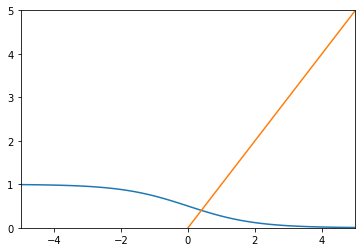

In [96]:
#
# Plotting
#
%matplotlib inline
import matplotlib.pyplot as plt

inp = torch.linspace(-5, 5, 100)

plt.plot(inp, f1(inp))
plt.plot(inp, inp.apply_(f0))
plt.xlim((-5,5))
plt.ylim((0,5))